In [57]:
# Задание 1

In [58]:
!pip install pycocotools
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../..

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975 (from 1)
Receiving objects: 100% (975/975), 11.72 MiB | 13.12 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
Compiling pycocotools/_mask.pyx because it changed.
[1/1] Cythonizing pycocotools/_mask.pyx
/usr/local/lib/python3.11/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build/temp.linux-x86_64-cpython-311/../common
creating build/temp.linux-x86_64-cpython-311/pycocotools
x86_64-linux-gnu-gcc -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -

In [60]:
import os
import zipfile
import requests

# Создание директорий
os.makedirs('coco/annotations', exist_ok=True)
os.makedirs('coco/train2017', exist_ok=True)
os.makedirs('coco/val2017', exist_ok=True)

# Функция для скачивания файлов
def download_file(url, save_path):
    response = requests.get(url, stream=True)
    with open(save_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

# Скачивание аннотаций (пример для train2017)
annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
annotations_zip_path = 'coco/annotations_trainval2017.zip'

print("Downloading annotations...")
download_file(annotations_url, annotations_zip_path)

# Распаковка аннотаций
print("Extracting annotations...")
with zipfile.ZipFile(annotations_zip_path, 'r') as zip_ref:
    zip_ref.extractall('coco/')

# Скачивание изображений для демонстрации
train_images_url = 'http://images.cocodataset.org/zips/train2017.zip'
train_zip_path = 'coco/train2017.zip'

print("Downloading train images...")
download_file(train_images_url, train_zip_path)

# Распаковка изображений
print("Extracting train images...")
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('coco/')

Extracting annotations...
Extracting train images...


In [62]:
from pycocotools.coco import COCO

dataDir = 'coco'
dataType = 'train2017'
annFile = f'{dataDir}/annotations/instances_{dataType}.json'

try:
    coco = COCO(annFile)
    print("COCO API initialized successfully!")
    print(f"Number of images: {len(coco.imgs)}")
except Exception as e:
    print(f"Error initializing COCO API: {e}")

loading annotations into memory...
Done (t=19.57s)
creating index...
index created!
COCO API initialized successfully!
Number of images: 118287


In [63]:
# Возьмем только первые 1000 изображений с людьми для демонстрации
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds)[:1000]
print(f"Working with {len(imgIds)} images containing people")

Working with 1000 images containing people


In [65]:
import cv2
import numpy as np
from tqdm import tqdm

def load_and_preprocess(coco, img_id, target_size=(512, 512)):
    # Загрузка информации об изображении
    img_info = coco.loadImgs(img_id)[0]
    img_path = f"coco/{dataType}/{img_info['file_name']}"

    # Загрузка и предобработка изображения
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0

    # Создание маски для людей
    annIds = coco.getAnnIds(imgIds=img_id, catIds=catIds)
    anns = coco.loadAnns(annIds)

    mask = np.zeros(target_size[::-1])  # (height, width)
    for ann in anns:
        if 'segmentation' in ann:
            seg = ann['segmentation']
            if isinstance(seg, list):
                for poly in seg:
                    poly = np.array(poly).reshape((-1, 2))
                    poly[:, 0] = poly[:, 0] * (target_size[0] / img_info['width'])
                    poly[:, 1] = poly[:, 1] * (target_size[1] / img_info['height'])
                    cv2.fillPoly(mask, [poly.astype(np.int32)], 1)

    return img, mask

# Пример загрузки одного изображения
sample_img, sample_mask = load_and_preprocess(coco, imgIds[0])

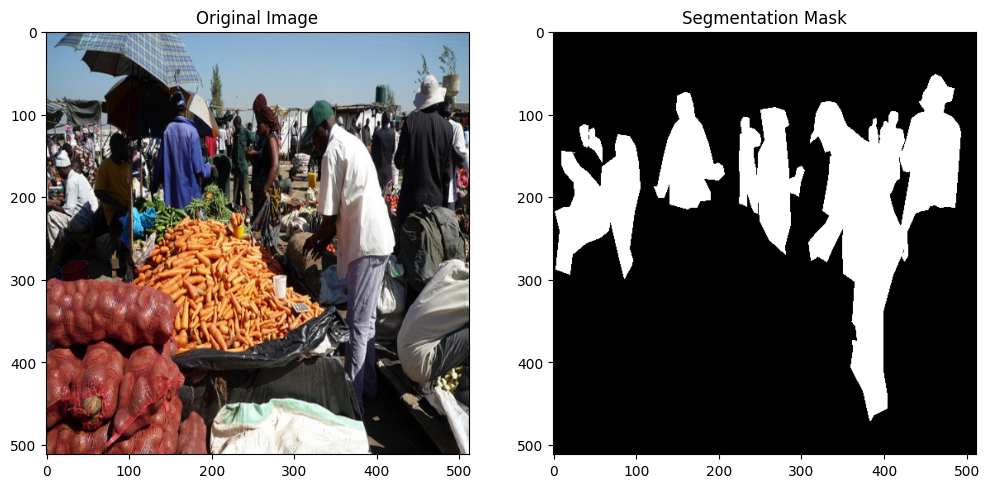

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap='gray')
plt.title("Segmentation Mask")
plt.show()

In [67]:
!pip install torch torchvision
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn

model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

def segment_with_maskrcnn(img):
    # Преобразование изображения в тензор
    img_tensor = torchvision.transforms.functional.to_tensor(img)

    # Предсказание
    with torch.no_grad():
        prediction = model([img_tensor])

    # Фильтрация только людей (класс 1)
    masks = prediction[0]['masks'][prediction[0]['labels'] == 1].numpy()
    scores = prediction[0]['scores'][prediction[0]['labels'] == 1].numpy()

    # Объединение масок с учетом confidence score
    combined_mask = np.zeros(img.shape[:2])
    for i in range(masks.shape[0]):
        if scores[i] > 0.5:  # Порог уверенности
            combined_mask = np.logical_or(combined_mask, masks[i, 0] > 0.5)

    return combined_mask.astype(np.float32)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 808.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 171MB/s]


In [68]:
!pip install ultralytics
from ultralytics import YOLO

yolo = YOLO('yolov8n-seg.pt')  # Nano-версия с сегментацией

def segment_with_yolo(img):
    results = yolo(img)
    mask = np.zeros(img.shape[:2])
    for result in results:
        if result.masks is not None:
            for m in result.masks:
                mask = np.logical_or(mask, m.data[0].numpy())
    return mask.astype(np.float32)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.74M/6.74M [00:00<00:00, 137MB/s]


In [70]:
def segment_with_maskrcnn(img):
    # Преобразование изображения в тензор и приведение к float32
    img_tensor = torchvision.transforms.functional.to_tensor(img).float()

    # Предсказание
    with torch.no_grad():
        prediction = model([img_tensor])

    # Фильтрация только людей (класс 1)
    masks = prediction[0]['masks'][prediction[0]['labels'] == 1].cpu().numpy()
    scores = prediction[0]['scores'][prediction[0]['labels'] == 1].cpu().numpy()

    # Объединение масок с учетом confidence score
    combined_mask = np.zeros(img.shape[:2], dtype=np.float32)
    for i in range(masks.shape[0]):
        if scores[i] > 0.5:  # Порог уверенности
            combined_mask = np.logical_or(combined_mask, masks[i, 0] > 0.5)

    return combined_mask.astype(np.float32)


0: 640x640 9 persons, 1 backpack, 4 umbrellas, 11.5ms
Speed: 6.8ms preprocess, 11.5ms inference, 411.9ms postprocess per image at shape (1, 3, 640, 640)
YOLO error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


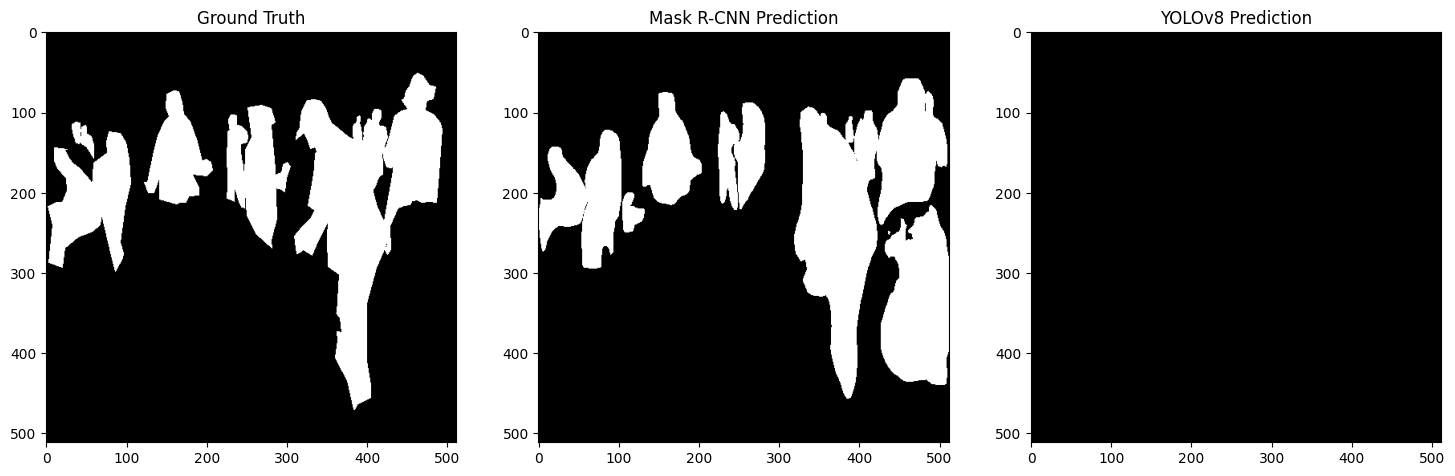

Mask R-CNN IoU: 0.619
YOLOv8 IoU: 0.000

0: 640x640 1 person, 1 backpack, 25.7ms
Speed: 3.9ms preprocess, 25.7ms inference, 35.4ms postprocess per image at shape (1, 3, 640, 640)
YOLO error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


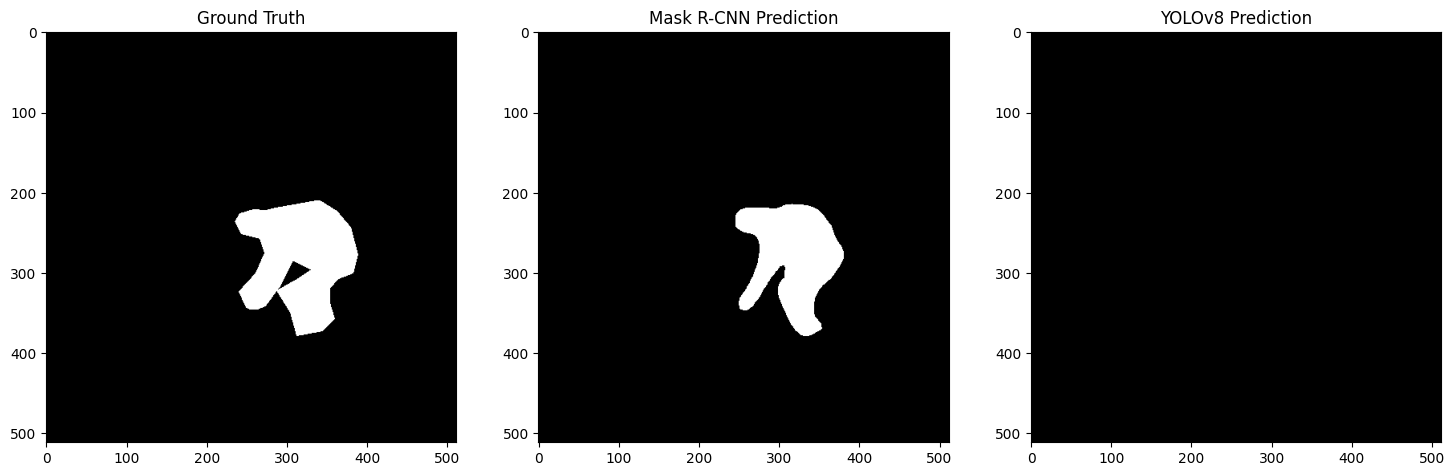

Mask R-CNN IoU: 0.761
YOLOv8 IoU: 0.000

0: 640x640 1 person, 2 dogs, 1 surfboard, 11.0ms
Speed: 5.3ms preprocess, 11.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
YOLO error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


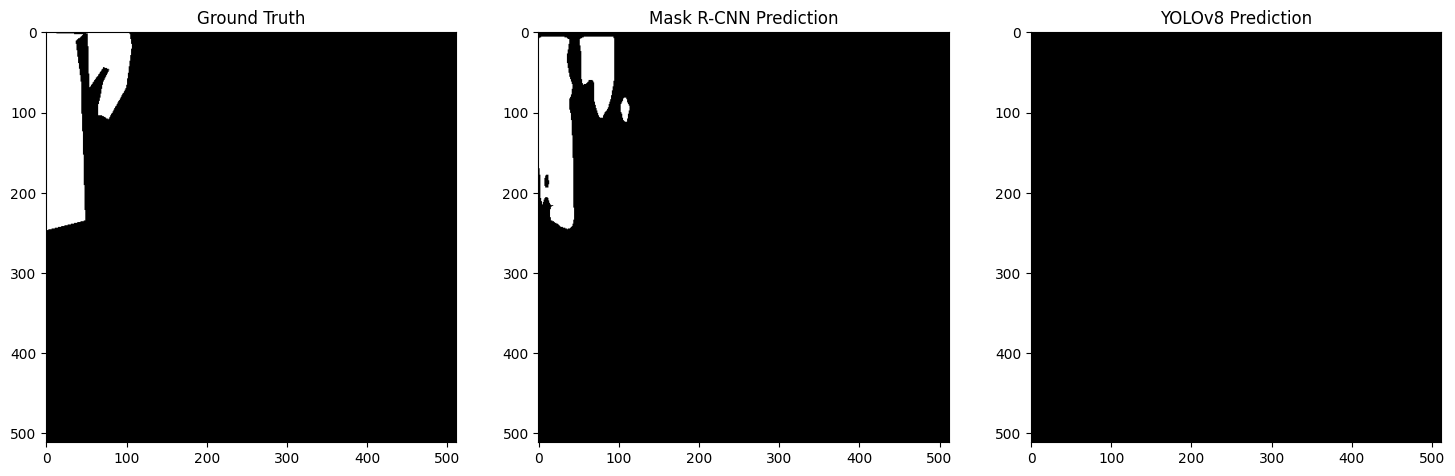

Mask R-CNN IoU: 0.773
YOLOv8 IoU: 0.000


In [71]:
def compare_models(img_id):
    # Загрузка изображения и маски
    img, true_mask = load_and_preprocess(coco, img_id)

    # Конвертация изображения в правильный формат
    img_uint8 = (img * 255).astype(np.uint8)  # Для YOLO
    img_float32 = img.astype(np.float32)       # Для Mask R-CNN

    # Mask R-CNN
    try:
        maskrcnn_result = segment_with_maskrcnn(img_float32)
    except Exception as e:
        print(f"Mask R-CNN error: {e}")
        maskrcnn_result = np.zeros_like(true_mask)

    # YOLOv8
    try:
        yolo_result = segment_with_yolo(img_uint8)
    except Exception as e:
        print(f"YOLO error: {e}")
        yolo_result = np.zeros_like(true_mask)

    # Визуализация
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 2)
    plt.imshow(maskrcnn_result, cmap='gray')
    plt.title("Mask R-CNN Prediction")

    plt.subplot(1, 3, 3)
    plt.imshow(yolo_result, cmap='gray')
    plt.title("YOLOv8 Prediction")

    plt.show()

    # Расчет IoU
    def calculate_iou(mask1, mask2):
        intersection = np.logical_and(mask1 > 0.5, mask2 > 0.5)
        union = np.logical_or(mask1 > 0.5, mask2 > 0.5)
        return np.sum(intersection) / (np.sum(union) + 1e-6)  # Добавляем небольшое значение для избежания деления на 0

    iou_rcnn = calculate_iou(true_mask, maskrcnn_result)
    iou_yolo = calculate_iou(true_mask, yolo_result)

    print(f"Mask R-CNN IoU: {iou_rcnn:.3f}")
    print(f"YOLOv8 IoU: {iou_yolo:.3f}")

# Сравнение на 3 примерах
for img_id in imgIds[:3]:
    compare_models(img_id)

In [73]:
def load_and_preprocess(coco, img_id, target_size=(512, 512)):
    try:
        img_info = coco.loadImgs(img_id)[0]
        img_path = f"coco/{dataType}/{img_info['file_name']}"

        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Could not load image {img_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img = img.astype(np.float32) / 255.0

        # Создание маски
        annIds = coco.getAnnIds(imgIds=img_id, catIds=catIds)
        anns = coco.loadAnns(annIds)

        mask = np.zeros(target_size[::-1], dtype=np.float32)
        for ann in anns:
            if 'segmentation' in ann:
                seg = ann['segmentation']
                if isinstance(seg, list):
                    for poly in seg:
                        poly = np.array(poly).reshape((-1, 2))
                        poly[:, 0] = poly[:, 0] * (target_size[0] / img_info['width'])
                        poly[:, 1] = poly[:, 1] * (target_size[1] / img_info['height'])
                        cv2.fillPoly(mask, [poly.astype(np.int32)], 1)

        return img, mask

    except Exception as e:
        print(f"Error processing image {img_id}: {e}")
        # Возвращаем пустое изображение и маску
        empty_img = np.zeros((*target_size, 3), dtype=np.float32)
        empty_mask = np.zeros(target_size[::-1], dtype=np.float32)
        return empty_img, empty_mask

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = maskrcnn_resnet50_fpn(pretrained=True).to(device).eval()

def segment_with_maskrcnn(img):
    img_tensor = torchvision.transforms.functional.to_tensor(img).float().to(device)
    results = yolo(img)
    mask = np.zeros(img.shape[:2], dtype=np.float32)
    for result in results:
        if hasattr(result, 'masks') and result.masks is not None:
            for m in result.masks:
                mask = np.logical_or(mask, m.data[0].cpu().numpy())
    return mask.astype(np.float32)

In [76]:
def batch_segment_with_maskrcnn(imgs):
    img_tensors = [torchvision.transforms.functional.to_tensor(img).float() for img in imgs]
    img_tensors = torch.stack(img_tensors).to(device)

    with torch.no_grad():
        predictions = model(img_tensors)

    results = []
    for pred in predictions:
        masks = pred['masks'][pred['labels'] == 1].cpu().numpy()
        scores = pred['scores'][pred['labels'] == 1].cpu().numpy()

        combined_mask = np.zeros(img.shape[:2], dtype=np.float32)
        for i in range(masks.shape[0]):
            if scores[i] > 0.5:
                combined_mask = np.logical_or(combined_mask, masks[i, 0] > 0.5)
        results.append(combined_mask)

    return results

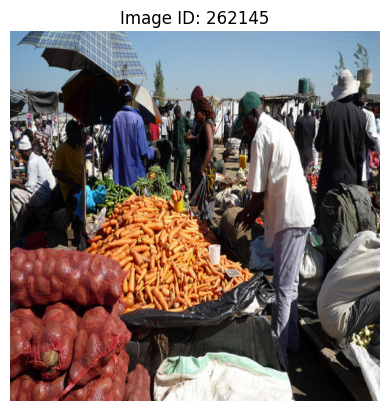

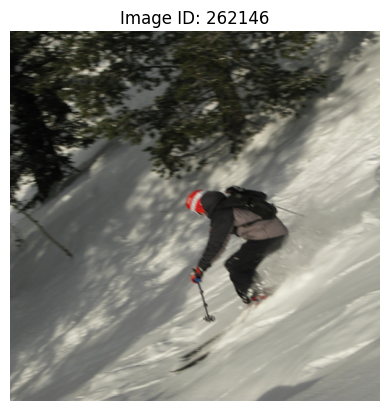

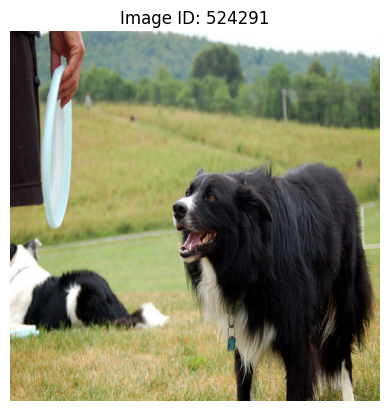

In [78]:
# Проверим загружаются ли изображения правильно
for img_id in imgIds[:3]:
    img, _ = load_and_preprocess(coco, img_id)
    plt.imshow(img)
    plt.title(f"Image ID: {img_id}")
    plt.axis('off')
    plt.show()

In [84]:
def segment_with_yolo(img, conf_thresh=0.25, target_size=(512, 512)):
    # Конвертируем в uint8 если нужно
    if img.dtype == np.float32:
        img = (img * 255).astype(np.uint8)

    # Увеличиваем confidence threshold для людей
    results = yolo(img, classes=[0], conf=conf_thresh)  # class 0 = person

    # Создаём пустую маску
    mask = np.zeros(target_size[::-1], dtype=np.float32)  # (height, width)

    # Обрабатываем результаты
    for result in results:
        if result.masks is not None:
            for m in result.masks:
                # Получаем маску и изменяем размер до target_size
                m_resized = cv2.resize(m.data[0].cpu().numpy().astype(np.uint8),
                                     target_size,
                                     interpolation=cv2.INTER_NEAREST)
                mask = np.logical_or(mask, m_resized)

    return mask.astype(np.float32)

In [83]:
def calculate_iou(mask1, mask2):
    """
    Вычисляет Intersection over Union (IoU) между двумя масками

    Параметры:
    mask1, mask2: numpy массивы одинакового размера с бинарными значениями (0 или 1)

    Возвращает:
    Значение IoU (от 0 до 1)
    """
    intersection = np.logical_and(mask1 > 0.5, mask2 > 0.5).sum()
    union = np.logical_or(mask1 > 0.5, mask2 > 0.5).sum()
    return intersection / (union + 1e-6)  # Добавляем небольшое значение чтобы избежать деления на 0


0: 640x640 9 persons, 12.2ms
Speed: 4.5ms preprocess, 12.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


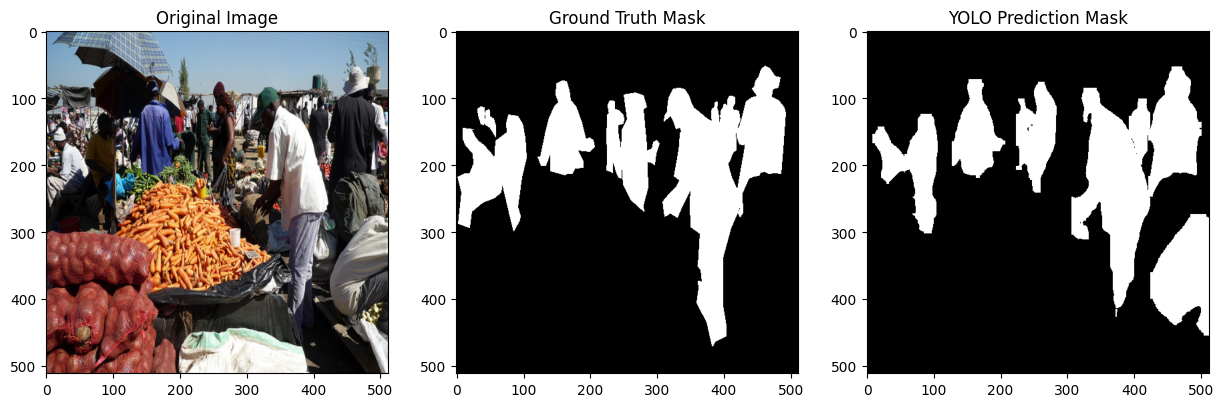

IoU Score: 0.644


In [85]:
# Загружаем одно изображение для теста
img_id = imgIds[0]  # берем первое изображение с человеком
img, true_mask = load_and_preprocess(coco, img_id)

# Выполняем сегментацию
yolo_mask = segment_with_yolo(img, conf_thresh=0.25)

# Визуализация
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='gray')
plt.title("Ground Truth Mask")

plt.subplot(1, 3, 3)
plt.imshow(yolo_mask, cmap='gray')
plt.title("YOLO Prediction Mask")

plt.show()

# Расчет IoU
iou_score = calculate_iou(true_mask, yolo_mask)
print(f"IoU Score: {iou_score:.3f}")


0: 640x640 15 persons, 9.7ms
Speed: 3.7ms preprocess, 9.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


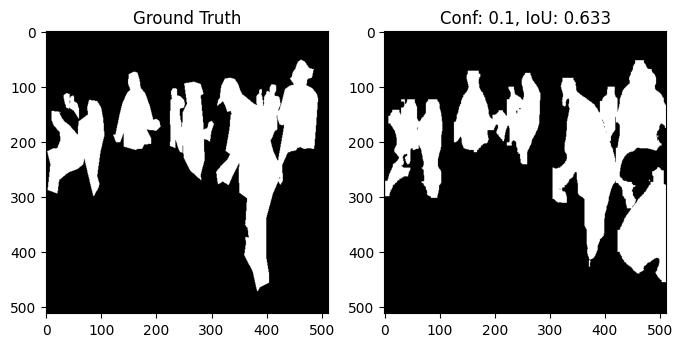


0: 640x640 9 persons, 13.4ms
Speed: 7.6ms preprocess, 13.4ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


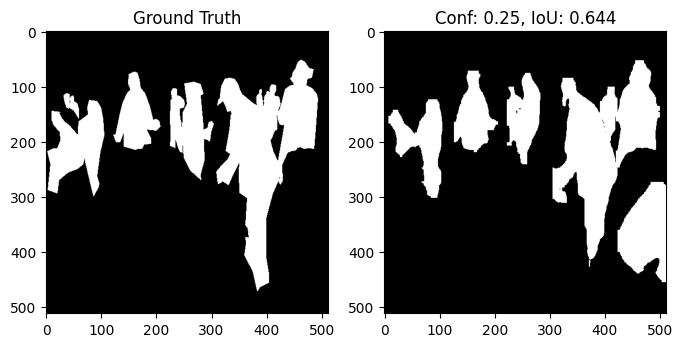


0: 640x640 6 persons, 20.1ms
Speed: 4.1ms preprocess, 20.1ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)


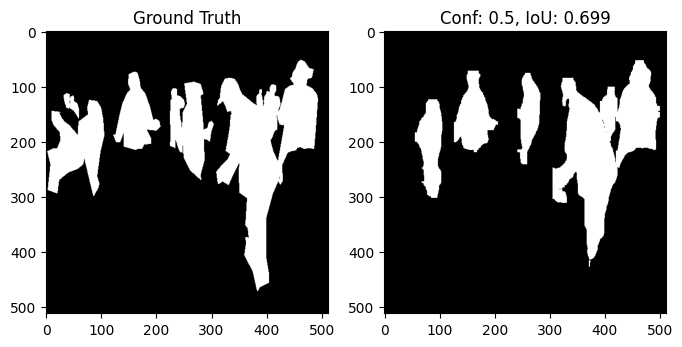


0: 640x640 2 persons, 11.7ms
Speed: 5.3ms preprocess, 11.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


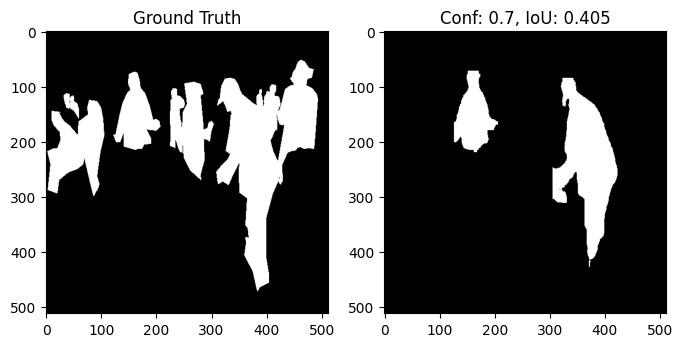

In [86]:
# Тестируем с разными порогами уверенности
for conf in [0.1, 0.25, 0.5, 0.7]:
    yolo_mask = segment_with_yolo(img, conf_thresh=conf)
    iou = calculate_iou(true_mask, yolo_mask)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1, 2, 2)
    plt.imshow(yolo_mask, cmap='gray')
    plt.title(f"Conf: {conf}, IoU: {iou:.3f}")
    plt.show()

In [87]:
# Сохранение визуализации
def save_results(img_id, save_dir="results"):
    os.makedirs(save_dir, exist_ok=True)

    img, true_mask = load_and_preprocess(coco, img_id)
    pred_mask = segment_with_yolo(img)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Prediction")

    save_path = os.path.join(save_dir, f"result_{img_id}.png")
    plt.savefig(save_path)
    plt.close()

    return save_path

# Сохраняем результаты для первых 5 изображений
for img_id in imgIds[:5]:
    save_results(img_id)


0: 640x640 9 persons, 11.0ms
Speed: 3.9ms preprocess, 11.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 23.1ms
Speed: 4.1ms preprocess, 23.1ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.7ms
Speed: 8.4ms preprocess, 14.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 persons, 11.2ms
Speed: 3.9ms preprocess, 11.2ms inference, 23.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 14.1ms
Speed: 3.9ms preprocess, 14.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
